<a href="https://colab.research.google.com/github/agerk/deepLearning/blob/master/sentiment_analysis_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Sentiment Analysis and Prediction

- Training the model on a dataset of movie reviews from IMDB that have been labeled either "positive" or "negative". This text data has words in sequence and it lends itself for RNN. 

- RNN model takes into account not only the individual words, but also the order they appear in and resulted a powerful model for sentiment prediciton. 

In [2]:
!pip install torch torchvision
!pip install --no-cache-dir -I pillow

    100% |████████████████████████████████| 2.0MB 37.4MB/s 


In [62]:
print(torch.__version__)

1.0.0


In [0]:
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

In [0]:
%matplotlib inline

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


Load Data

In [7]:
from google.colab import files

# Load data
data = files.upload()
!ls /tmp/nst

Saving labels.txt to labels.txt
Saving reviews.txt to reviews.txt


In [85]:
# open text file and read in data as `text`
with open('reviews.txt', 'r') as f:
    reviews = f.read()
with open('labels.txt', 'r') as f:
    labels = f.read()
  
print(reviews[:1000])
print()
print(labels[:20])

bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   
story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is turn

## Data pre-processing

The first step when building a neural network model is getting your data into the proper form to feed into the network. Since we're using embedding layers, we'll need to encode each word with an integer. We'll also want to clean it up a bit.

You can see an example of the reviews data above. Here are the processing steps, we'll want to take:
>* Get rid of periods and extraneous punctuation.
* Also, you might notice that the reviews are delimited with newline characters `\n`. To deal with those, and split the text into each review using `\n` as the delimiter. 
* Then combined all the reviews back together into one big string.

First, let's remove all punctuation. Then get all the text without the newlines and split it into individual words.

In [9]:
from string import punctuation

print(punctuation)

# get rid of punctuations
reviews = reviews.lower()
all_text = ''.join([c for c in reviews if c not in punctuation])
print(all_text[:100])

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life 


In [10]:
# split by new lines and spaces
reviews_split = all_text.split('\n')
all_text = ''.join(reviews_split)

print(all_text[:30])

# create a list of words
words = all_text.split()
words[:30]

bromwell high is a cartoon com


['bromwell',
 'high',
 'is',
 'a',
 'cartoon',
 'comedy',
 'it',
 'ran',
 'at',
 'the',
 'same',
 'time',
 'as',
 'some',
 'other',
 'programs',
 'about',
 'school',
 'life',
 'such',
 'as',
 'teachers',
 'my',
 'years',
 'in',
 'the',
 'teaching',
 'profession',
 'lead',
 'me']

### Encoding the words

The embedding lookup requires that we pass in integers to our network. The easiest way to do this is to create dictionaries that map the words in the vocabulary to integers. Then we can convert each of our reviews into integers so they can be passed into the network.


In [0]:
from collections import  Counter

# build a dictionary that maps words to integers
counts = Counter(words)   # create a dict of word counts
vocab = sorted(counts, key=counts.get, reverse=True)    # get unique voca
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}   # start from index 1
# print(vocab)
# print(vocab_to_int)

# tokenize each review 
reviews_ints = []
for review in reviews_split:
  reviews_ints.append([vocab_to_int[word] for word in review.split()])
  
# print(reviews_ints[:1])  



In [83]:
# Test encoding code
print('Unique words: ', len((vocab_to_int)))    # Should be 74000+
print()

# print token first review
print('Tokenized review: \n', reviews_ints[:1])

Unique words:  74072

Tokenized review: 
 [[21025, 308, 6, 3, 1050, 207, 8, 2138, 32, 1, 171, 57, 15, 49, 81, 5785, 44, 382, 110, 140, 15, 5194, 60, 154, 9, 1, 4975, 5852, 475, 71, 5, 260, 12, 21025, 308, 13, 1978, 6, 74, 2395, 5, 613, 73, 6, 5194, 1, 24103, 5, 1983, 10166, 1, 5786, 1499, 36, 51, 66, 204, 145, 67, 1199, 5194, 19869, 1, 37442, 4, 1, 221, 883, 31, 2988, 71, 4, 1, 5787, 10, 686, 2, 67, 1499, 54, 10, 216, 1, 383, 9, 62, 3, 1406, 3686, 783, 5, 3483, 180, 1, 382, 10, 1212, 13583, 32, 308, 3, 349, 341, 2913, 10, 143, 127, 5, 7690, 30, 4, 129, 5194, 1406, 2326, 5, 21025, 308, 10, 528, 12, 109, 1448, 4, 60, 543, 102, 12, 21025, 308, 6, 227, 4146, 48, 3, 2211, 12, 8, 215, 23]]


### Encoding the labels

Our labels are "positive" or "negative". To use these labels in our network, we need to convert them to 0 and 1.

- Convert labels from `positive` and `negative` to 1 and 0, respectively, and place those in a new list, `encoded_labels`.

In [99]:
# # 1=positive, 0=negative label conversion
labels_split = labels.split('\n')
encoded_labels = np.array([1 if label =='positive' else 0 for label in labels_split])
encoded_labels

array([1, 0, 1, ..., 1, 0, 0])

### Removing Outliers

As an additional pre-processing step, we want to make sure that our reviews are in good shape for standard processing. That is, our network will expect a standard input text size, and so, we'll want to shape our reviews into a specific length. We'll approach this task in two main steps:

1. Getting rid of extremely long or short reviews; the outliers
2. Padding/truncating the remaining data so that we have reviews of the same length.

Before padding, we should check for reviews of extremely short or long lengths; outliers that may mess with our training.

In [100]:
# outlier review stats
review_lens = Counter([len(x) for x in reviews_ints])
print('Zero-length reviews: {}'.format(review_lens[0]))
print('Maximum review length: {}'.format(max(review_lens)))

Zero-length reviews: 0
Maximum review length: 2514


A couple issues here. We seem to have one review with zero length. And, the maximum review length is way too many steps for our RNN. We'll have to remove any super short reviews and truncate super long reviews. This removes outliers and should allow our model to train more efficiently.

- First, remove *any* reviews with zero length from the `reviews_ints` list and their corresponding label in `encoded_labels`.

In [108]:
print('Number of reviews before removing outliers: ', len(reviews_ints))

# remove any review/labels with zero length from the reviews_ints list
non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review) != 0]

# remove 0-length reviews and their labels
reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]
encoded_labels = np.array([encoded_labels[ii] for ii in non_zero_idx])

print('Number of reviews after removing outliers: ', len(reviews_ints))

Number of reviews before removing outliers:  25001
Number of reviews after removing outliers:  25000


---
## Padding sequences

To deal with both short and very long reviews, we'll pad or truncate all our reviews to a specific length. For reviews shorter than some `seq_length`, we'll pad with 0s. For reviews longer than `seq_length`, we can truncate them to the first `seq_length` words. A good `seq_length`, in this case, is 200.

- Define a function that returns an array `features` that contains the padded data, of a standard size, that we'll pass to the network. 
* The data should come from `review_ints`, since we want to feed integers to the network. 
* Each row should be `seq_length` elements long. 
* For reviews shorter than `seq_length` words, **left pad** with 0s. That is, if the review is `['best', 'movie', 'ever']`, `[117, 18, 128]` as integers, the row will look like `[0, 0, 0, ..., 0, 117, 18, 128]`. 
* For reviews longer than `seq_length`, use only the first `seq_length` words as the feature vector.

As a small example, if the `seq_length=10` and an input review is: 
```
[117, 18, 128]
```
The resultant, padded sequence should be: 

```
[0, 0, 0, 0, 0, 0, 0, 117, 18, 128]
```

**Final `features` array should be a 2D array, with as many rows as there are reviews, and as many columns as the specified `seq_length`.**

This isn't trivial and there are a bunch of ways to do this. But, if you're going to be building your own deep learning networks, you're going to have to get used to preparing your data.

In [0]:
def pad_features(reviews_ints, seq_length):
  """Return features of review_ints, where each review is padded with 0's
  or truncated to the input seq_length"""
  
  # getting the correct rows x cols shape
  features = np.zeros((len(reviews_ints), seq_length), dtype=int)
  
  # for each review, grab that review and put it as a row
  # fill out the index starting at the end of the feature row  -len(row): 
  # for left padding
  # for a new review including longer seq
  for i, row in enumerate(reviews_ints):
    
    features[i, -len(row):] = np.array(row)[:seq_length]   
                                                           
  
  return features
  

In [103]:
# check pad_features
seq_length = 200

features = pad_features(reviews_ints, seq_length=seq_length)

# test statements
assert len(features) == len(reviews_ints), "features should have as many rows as reviews"
assert len(features[0]) == seq_length, "each features row should contain seq_length values."
print(features[:20, :10])

[[    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [22382    42 46418    15   706 17139  3389    47    77    35]
 [ 4505   505    15     3  3342   162  8312  1652     6  4819]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [   54    10    14   116    60   798   552    71   364     5]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    1   330   578    34     3   162   748  2731     9   325]
 [    9    11 10171  5305  1946   689   444    22   280   673]
 [    0     0     0     0     0     0     0     0     0

## Training, Validation, Test

With our data in nice shape, we'll split it into training, validation, and test sets.

- Create the training, validation, and test sets. 
* You'll need to create sets for the features and the labels, `train_x` and `train_y`, for example. 
* Define a split fraction, `split_frac` as the fraction of data to **keep** in the training set. Usually this is set to 0.8 or 0.9. 
* Whatever data is left will be split in half to create the validation and *testing* data.

With train, validation, and test fractions equal to 0.8, 0.1, 0.1, respectively, the final, feature data shapes should look like

In [104]:
# split data into train, validation and test sets
split_fact = 0.8

split_idx = int(len(features)*split_fact)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

# split remaining 50/50 to valid and test set
valid_test_split = 0.5
test_idx = int(len(remaining_x)*valid_test_split)
valid_x, test_x  = remaining_x[:test_idx], remaining_x[test_idx:]
valid_y, test_y  = remaining_y[:test_idx], remaining_y[test_idx:]

# print out shapes
print("\t\t\tFeature Shapes:")
print("\t\t\t--------------")
print("Train set: \t\t{}".format(train_x.shape),
      "\nValidation set: \t{}".format(valid_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
			--------------
Train set: 		(20000, 200) 
Validation set: 	(2500, 200) 
Test set: 		(2500, 200)


---
## DataLoaders and Batching

After creating training, test, and validation data, we can create DataLoaders for this data by following two steps:
1. Create a known format for accessing our data, using [TensorDataset](https://pytorch.org/docs/stable/data.html#) which takes in an input set of data and a target set of data with the same first dimension, and creates a dataset.
2. Create DataLoaders and batch our training, validation, and test Tensor datasets.

```
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, batch_size=batch_size)
```

This is an alternative to creating a generator function for batching our data into full batches.

In [0]:
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloader
batch_size = 50

train_loader = DataLoader(train_data, batch_size=batch_size)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [106]:
# get one batch of training data
data_iter = iter(train_loader)
sample_x, sample_y = data_iter.next()

print('Sample input size: ', sample_x.size())    # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size())    # batch_size
print('Sample label: \n', sample_y)


Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[    0,     0,     0,  ...,     8,   215,    23],
        [    0,     0,     0,  ...,    29,   108,  3324],
        [22382,    42, 46418,  ...,   483,    17,     3],
        ...,
        [    0,     0,     0,  ...,    21,   397,   243],
        [    0,     0,     0,  ...,     7,  1969,  5153],
        [    0,     0,     0,  ...,  1511,    71,   350]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0])


In [23]:
data = files.upload()

Saving network_diagram.png to network_diagram.png


In [0]:
# from google.colab import drive
# drive.mount('/content/drive/')

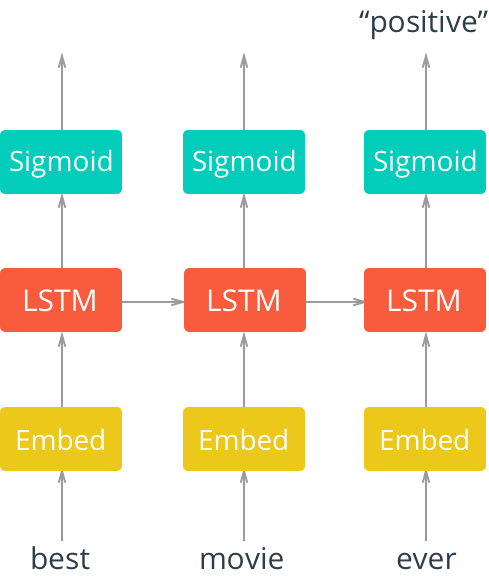

In [25]:
from IPython.display import Image
# %cd /tmp/nst
Image("network_diagram.png", width=300, height=300)

 ## Sentiment Network with PyTorch
 
See fig above for the network architecture
 
 The layers are as follows:
1. An [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) that converts our word tokens (integers) into embeddings of a specific size.
2. An [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) defined by a hidden_state size and number of layers
3. A fully-connected output layer that maps the LSTM layer outputs to a desired output_size
4. A sigmoid activation layer which turns all outputs into a value 0-1; return **only the last sigmoid output** as the output of this network.

### The Embedding Layer

We need to add an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) because there are 74000+ words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.


### The LSTM Layer(s)

We'll create an [LSTM](https://pytorch.org/docs/stable/nn.html#lstm) to use in our recurrent network, which takes in an input_size, a hidden_dim, a number of layers, a dropout probability (for dropout between multiple layers), and a batch_first parameter.

Most of the time, you're network will have better performance with more layers; between 2-3. Adding more layers allows the network to learn really complex relationships. 

> Complete the `__init__`, `forward`, and `init_hidden` functions for the SentimentRNN model class.

Note: `init_hidden` should initialize the hidden and cell state of an lstm layer to all zeros, and move those state to GPU, if available.

In [26]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [0]:
import torch.nn as nn

class SentimentRNN(nn.Module):
  """The RNN model that will be used to perform Sentiment analysis"""
  
  def __init__(self, vocab_size, output_size, embedding_dim, 
                hidden_dim, n_layers, drop_prob=0.5):
    """Initialize the model by setting up the layers"""
    
    super(SentimentRNN, self).__init__()
    
    # define input data
    self.output_size = output_size
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim
    
    # define all layers
    self.embedding = nn.Embedding(vocab_size, embedding_dim)    # serve as a dim
                                                                # reduction mtd
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                       dropout=drop_prob, batch_first=True)
    
    # dropout layer
    self.dropout = nn.Dropout(p=0.3)
    
    # linear and sigmoid layers
    self.fc = nn.Linear(hidden_dim, output_size)
    self.sig = nn.Sigmoid()
    
  def forward(self, x, hidden):
    """Perform a forward pass over model on input and hidden state"""
    
    # get bactch size of the input x
    batch_size = x.size(0)
    
    # pass x through the embedding to get embeding output
    embeds = self.embedding(x)
    
    # pass embedding and hidden state to lstm 
    lstm_out, hidden = self.lstm(embeds, hidden)
    
    # stack up lstm outputs to pass to last linear layer
    lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
#     lstm_out = lstm_out.view(-1, self.hidden_dim)
    
    # pass reshaped lstmout to a dropout and fully connected layers
    out = self.dropout(lstm_out)
    out = self.fc(out)
    
    # pass the output to sigmoid function
    sig_out = self.sig(out)
    
    # make sure only the last of the sig output is passed
    # reshape to be batch_size first
    sig_out = sig_out.view(batch_size, -1)
    sig_out = sig_out[:, -1]    # get the last batch of labels
    
    # return last sigmoid output and hidden state
    return sig_out, hidden
  
  def init_hidden(self, batch_size):
    """Initialize hidden state """
    
    # create two new tensors with sizez n_layers x batch_size x hidden_dim
    # initialized to zero, for hidden state and cell state of LSTM
    weight = next(self.parameters()).data
    
    if (train_on_gpu):
      hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
               weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
    else:
  
      hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
               weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
    
    return hidden 
    
    

### Hyperparameters
After defining my model, next I should instantiate it with some hyperparameters.

In [58]:
# Instantiate the model woth hyperparams

# unique words
vocab_size = len(vocab_to_int)+1    # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(74073, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Training and Optimization
The training code, should look pretty familiar. One new detail is that, we'll be using a new kind of cross entropy loss that is designed to work with a single Sigmoid output

>We'll also be using a new kind of cross entropy loss, which is designed to work with a single Sigmoid output. [BCELoss](https://pytorch.org/docs/stable/nn.html#bceloss), or **Binary Cross Entropy Loss**, applies cross entropy loss to a single value between 0 and 1.

We also have some data and training hyparameters:

* `lr`: Learning rate for our optimizer.
* `epochs`: Number of times to iterate through the training dataset.
* `clip`: The maximum gradient value to clip at (to prevent exploding gradients).

In [0]:
# loss and optimization functions
lr = 0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [111]:
# training params

epochs = 3
counter = 0
print_every = 100
clip = 5    # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
  net.cuda()

net.train()

# train for some number of epochs
for e in range(epochs):
  # initialize hidden state
  h = net.init_hidden(batch_size)
  
  # batch loop
  for inputs, labels in train_loader:
    counter += 1
    
    if(train_on_gpu):
      inputs, labels = inputs.cuda(), labels.cuda()
    
    # create new variable for the hidden state, oterwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])
    
    # sero accumlated gradients
    net.zero_grad()
    
    # get the output from the model
    output, h = net(inputs, h)
    
    # calculate the loss and perform backprop
    loss = criterion(output.squeeze(), labels.float())
    loss.backward()
    
    # clip_grad_norm help prevent the exploding gradient problem in RNN
    nn.utils.clip_grad_norm_(net.parameters(), clip)
    optimizer.step()
    
    # loss starts
    if counter % print_every == 0:
      # get validation loss
      val_h = net.init_hidden(batch_size)
      val_losses = []
      net.eval()
      
      for inputs, labels in valid_loader:
        # create new variable for the hidden state
        val_h = tuple([each.data for each in val_h])
        
        if(train_on_gpu):
          inputs, labels = inputs.cuda(), labels.cuda()
        
        output, val_h = net(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())
        val_losses.append(val_loss.item())
        
      net.train()
      print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/3... Step: 100... Loss: 0.019071... Val Loss: 0.244997
Epoch: 1/3... Step: 200... Loss: 0.005377... Val Loss: 0.627355
Epoch: 1/3... Step: 300... Loss: 0.003340... Val Loss: 1.028169
Epoch: 1/3... Step: 400... Loss: 0.001229... Val Loss: 1.316133
Epoch: 2/3... Step: 500... Loss: 0.031767... Val Loss: 0.759592
Epoch: 2/3... Step: 600... Loss: 0.004601... Val Loss: 2.880280
Epoch: 2/3... Step: 700... Loss: 0.002272... Val Loss: 3.132442
Epoch: 2/3... Step: 800... Loss: 0.001897... Val Loss: 3.309364
Epoch: 3/3... Step: 900... Loss: 0.057478... Val Loss: 0.125531
Epoch: 3/3... Step: 1000... Loss: 0.004311... Val Loss: 0.154187
Epoch: 3/3... Step: 1100... Loss: 0.001127... Val Loss: 0.212046
Epoch: 3/3... Step: 1200... Loss: 0.000727... Val Loss: 0.191017


---
## Testing

There are a few ways to test your network.

* **Test data performance:** First, we'll see how our trained model performs on all of our defined test_data, above. We'll calculate the average loss and accuracy over the test data.

* **Inference on user-generated data:** Second, we'll see if we can input just one example review at a time (without a label), and see what the trained model predicts. Looking at new, user input data like this, and predicting an output label, is called **inference**.

In [112]:
# get test data loss and accuracy
test_losses = []
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()

# iterate over test data
for inputs, labels in test_loader:
  
  # create new variable for the hidden state, otherwise
  # we'd backprop through the entire training history
  h = tuple([each.data for each in h])
  
  if(train_on_gpu):
    inputs, labels = inputs.cuda(), labels.cuda()
    
  # get prediction output
  output, h = net(inputs, h)
  
  # calculate loss
  test_loss = criterion(output.squeeze(), labels.float())
  test_losses.append(test_loss.item())
  
  # convert output probabilities to predicted class (0 or 1)
  pred = torch.round(output.squeeze())    # round to the nearset integer
  
  # compare predicitions to true label
  correct_tensor = pred.eq(labels.float().view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else \
    np.squeeze(correct_tensor.cpu().numpy())
  num_correct += np.sum(correct)
  
# get stats
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))
  
   
  

Test loss: 0.349
Test accuracy: 0.920


### Inference on a test review

You can change this test_review to any text that you want. Read it and think: is it pos or neg? Then see if your model predicts correctly!
    
>  Write a `predict` function that takes in a trained net, a plain text_review, and a sequence length, and prints out a custom statement for a positive or negative review!


In [0]:
# negative test review
test_review_neg = 'The worst movie I have seen; acting was terrible and \
I want my money back. This movie had bad acting and the dialogue was slow.'


In [0]:
from string import punctuation

def tokenize_review(test_review):
 
  # lowercase
  test_review = test_review.lower()
  # remove puncs
  test_text = ''.join([c for c in test_review if c not in punctuation])
  # split by space
  test_words = test_text.split()
  # tokenization
  test_ints = []
  test_ints.append([vocab_to_int[word] for word in test_words])
  
  return test_ints  

In [132]:
# test code and generate tokenized review
test_ints = tokenize_review(test_review_neg)
print(test_ints)

[[1, 247, 18, 10, 28, 108, 113, 14, 388, 2, 10, 181, 60, 273, 144, 11, 18, 68, 76, 113, 2, 1, 410, 14, 539]]


Padding and converting into a Tensor


In [133]:
# test sequence padding
seq_length=200
features = pad_features(test_ints, seq_length)

print(features)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   1 247  18  10  28
  108 113  14 388   2  10 181  60 273 144  11  18  68  76 113   2   1 410
   14 539]]


In [0]:
def predict(net, test_review, sequence_length=200):
  """Perdicit whether a given review is positive or negative
  Args:
    net: a trained lstm network
    test_review: a review of normal text
    squence_length: padded length of a review
  """
    
  # tokenize review
  test_ints = tokenize_review(test_review)
    
  # pad tokenized sequence
  seq_length = sequence_length
  features = pad_features(test_ints, seq_length)
   
  # convert to tensor to pass into model
  feature_tensor = torch.from_numpy(features)
  batch_size = feature_tensor.size(0)
    
  # initialize hidden state
  h = net.init_hidden(batch_size)
    
  if(train_on_gpu):
    feature_tensor = feature_tensor.cuda()
    
  # get the output from the model
  output, h = net(feature_tensor, h)
    
  # convert output probabilities to predicted class (0 or 1)
  pred = torch.round(output.squeeze())
  print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    
  if(pred.item()==1):
     print('Positive review detected')
  else:
      print("Negative review detected")

In [143]:
# positive test review
test_review_pos = 'This movie had the best acting and the dialogue was so good. I loved it.'
# call function
seq_length=200 # good to use the length that was trained on

predict(net, test_review_neg, seq_length)

Prediction value, pre-rounding: 0.000972
Negative review detected


*Note: This notebook is based on the Intro to PyTorch course on Udacity*